In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle

from stn.conv_model import conv_model
from stn.conv_model import conv_model_no_color_adjust
from sklearn.utils import resample
from lib.utils import load_gtsrb
from keras.metrics import sparse_categorical_accuracy

from parameters import *
from small_net import *

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
signnames = pd.read_csv(DATA_DIR + 'signnames.csv')
X_train, y_train, X_val, y_val, X_test, y_test = load_gtsrb()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

model = conv_model_no_color_adjust()
# model = conv_model()
model.load_weights("./keras_weights/stn_v5.hdf5")

get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[1].output])
stn_weight = model.layers[1].get_weights()

In [3]:
def get_patch(X, pos):
    """
    Crop all samples in <X> to make a set of patches <X_cropped>
    at the same position <pos>
    """
    
    top, bot, left, right = pos
    X_cropped = np.zeros((X.shape[0], bot - top, right - left, X.shape[3]))
    for i, x in enumerate(X):
        X_cropped[i] = np.copy(x[top:bot, left:right, :])
    return X_cropped

# Define cropping positions
pos_2 = (7, 23, 5, 17)
pos_0 = (7, 24, 15, 27) # Good for class 0 - 5
pos_3 = (7, 24, 6, 17)

pos_S = (7, 24, 0, 11)
pos_T = (7, 23, 8, 17)
pos_O = (6, 23, 13, 24)
pos_P = (6, 23, 22, 32)

pos_y11 = (11, 27, 9, 21)

In [4]:
r = 1
X_train_bal, y_train_bal = gen_balance_data(X_train, y_train, [14], r=r)
y_train_bal = y_train_bal[:, np.newaxis]
X_val_bal, y_val_bal = gen_balance_data(X_val, y_val, [14], r=r)
y_val_bal = y_val_bal[:, np.newaxis]
X_test_bal, y_test_bal = gen_balance_data(X_test, y_test, [14], r=r)
y_test_bal = y_test_bal[:, np.newaxis]

y_test_stn = np.zeros([len(y_test), 1])
y_test_stn[np.where(y_test == 14)] = 1

In [32]:
from cleverhans.attacks import FastGradientMethod, CarliniWagnerL2
from cleverhans.utils import set_log_level
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval
import logging

n_attack = 250
ind_1 = np.where(y_test == 1)[0]
X_atk = X_test[ind_1][:n_attack]

y_target = np.zeros((n_attack, )) + 14
y_target = to_categorical(y_target, 43)

---

In [52]:
# from ensemble_feat_net import FeatNet
from feat_net import FeatNet

thres = {"thres_type": "diff",
         "thres_range": [[0.95, 0.05], [0.3, 1.2], [-0.2, 1.2]], 
         "thres_steep": 100
        }
featnet = FeatNet("featnet_v11", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  hsv=True,
                  thres=None,
                  learning_rate=1e-4, 
                  reg=1e-3,
                  save_path="model/featnet_v11.h5",
                  load_model=False,
                  stn_weight=stn_weight)
data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, dataaug=True, n_epoch=10, batch_size=128, thres=0.75)

============= EPOCH: 0 =============
STEP: 0 	Loss: 0.1383
STEP: 50 	Loss: -0.4614
STEP: 100 	Loss: -1.0924
STEP: 150 	Loss: -1.1871
STEP: 200 	Loss: -1.5242
STEP: 250 	Loss: -1.7140
STEP: 300 	Loss: -1.7884
STEP: 350 	Loss: -1.5480
STEP: 400 	Loss: -1.5869
STEP: 450 	Loss: -1.8019
STEP: 500 	Loss: -1.8157
Train Acc|Loss:	0.9837|-1.8128
Val Acc|Loss:	0.9831|-1.8117
============= EPOCH: 1 =============
STEP: 0 	Loss: -1.8072
STEP: 50 	Loss: -1.5021
STEP: 100 	Loss: -1.7872
STEP: 150 	Loss: -1.6346
STEP: 200 	Loss: -1.6935
STEP: 250 	Loss: -1.6465
STEP: 300 	Loss: -1.6687
STEP: 350 	Loss: -2.2892
STEP: 400 	Loss: -1.7196
STEP: 450 	Loss: -1.6590
STEP: 500 	Loss: -1.7195
Train Acc|Loss:	0.9840|-1.8824
Val Acc|Loss:	0.9839|-1.8774
============= EPOCH: 2 =============
STEP: 0 	Loss: -1.9374
STEP: 50 	Loss: -1.5156
STEP: 100 	Loss: -1.9190
STEP: 150 	Loss: -1.8205
STEP: 200 	Loss: -1.7438
STEP: 250 	Loss: -1.7301
STEP: 300 	Loss: -1.6192
STEP: 350 	Loss: -1.7521
STEP: 400 	Loss: -1.8219
STEP

In [53]:
featnet.eval_model(sess, (X_test_bal, y_test_bal), thres=0.75)

(0.9947006472491909, -1.9323746238132897)

In [54]:
get_output = K.function([featnet.model.layers[0].input],
                        [featnet.model.layers[5].output])
get_stn = K.function([featnet.model.layers[0].input],
                     [featnet.model.layers[3].output])
get_hsv = K.function([featnet.model.layers[0].input],
                     [featnet.model.layers[4].output])

In [57]:
pred = featnet.predict_model(sess, X_test)
ind1 = np.squeeze(pred < 3)
ind2 = y_test == 14
ind = np.where(np.logical_and(ind1, ind2))[0]
X = X_test[ind]
Y = y_test[ind]

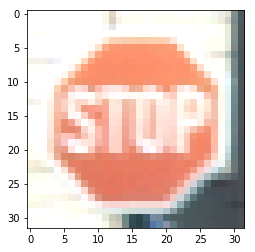

In [58]:
for i in X[:10]:
    plt.imshow(i)
    plt.show()

[array([[0.9552424]], dtype=float32), array([[0.99853206]], dtype=float32), array([[0.80999875]], dtype=float32), array([[0.00070599]], dtype=float32)]
[array([[3.0607042]], dtype=float32), array([[6.5224724]], dtype=float32), array([[1.4500021]], dtype=float32), array([[-7.2551985]], dtype=float32)]


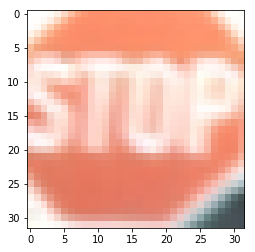

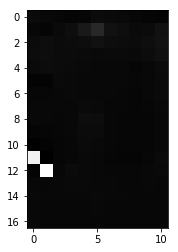

ValueError: could not broadcast input array from shape (10,11,3) into shape (17,11,3)

In [59]:
x = X[0][np.newaxis]

y = get_output([x])[0]

feed_dict = {featnet.model.get_input_at(0): x}
scores = sess.run([featnet.feat_scores, featnet.before_sigmoid], feed_dict=feed_dict)
print(scores[0])
print(scores[1])

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()

In [19]:
X = X_train[np.where(y_train == 14)[0]]

[array([[0.9994665]], dtype=float32), array([[0.999879]], dtype=float32), array([[0.9993405]], dtype=float32), array([[0.99996364]], dtype=float32), array([[0.9999099]], dtype=float32), array([[0.9999999]], dtype=float32), array([[0.9993937]], dtype=float32), array([[0.9999244]], dtype=float32)]
[array([[7.5353494]], dtype=float32), array([[9.019862]], dtype=float32), array([[7.3232927]], dtype=float32), array([[10.221953]], dtype=float32), array([[9.314763]], dtype=float32), array([[15.791199]], dtype=float32), array([[7.4074917]], dtype=float32), array([[9.490405]], dtype=float32)]


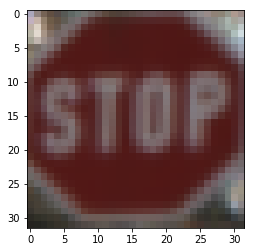

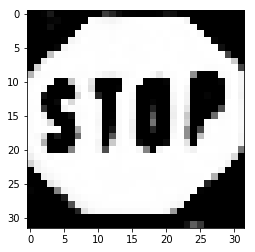

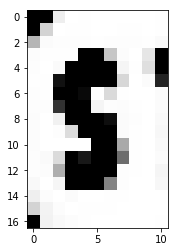

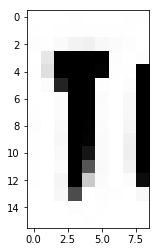

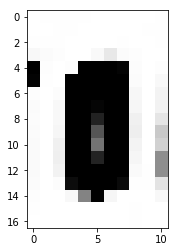

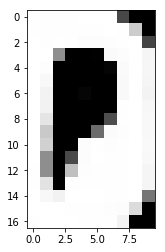

In [20]:
i = np.random.choice(len(X))

x = X[i][np.newaxis]
# x = X_train[np.where(y_train == 14)[0]][0][np.newaxis]

y = get_output([x])[0]

feed_dict = {featnet.model.get_input_at(0): x}
scores = sess.run([featnet.feat_scores, featnet.before_sigmoid], feed_dict=feed_dict)
print(scores[0])
print(scores[1])

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()

In [29]:
pred = featnet.predict_model(sess, X_test)
ind1 = np.squeeze(pred > 7)
ind2 = y_test != 14
ind = np.where(np.logical_and(ind1, ind2))[0]
X = X_test[ind]
y = y_test[ind]

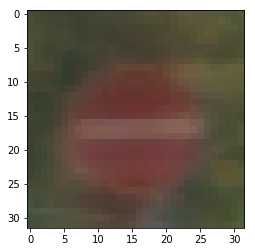

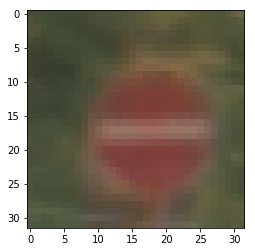

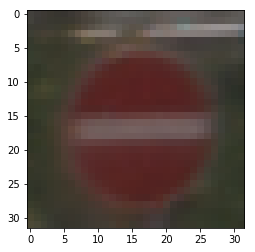

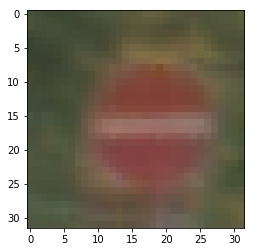

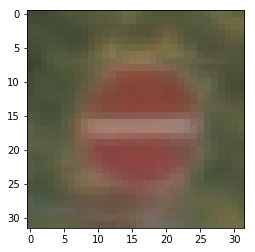

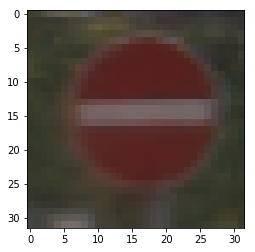

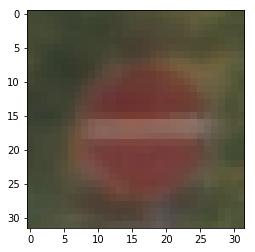

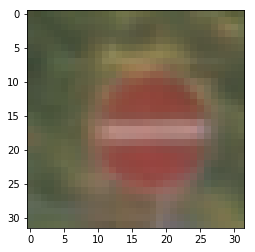

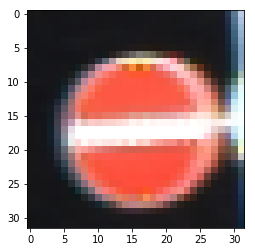

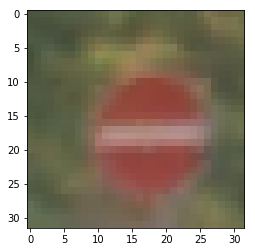

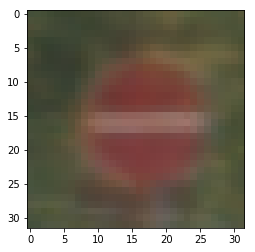

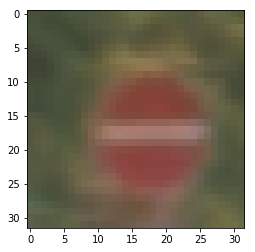

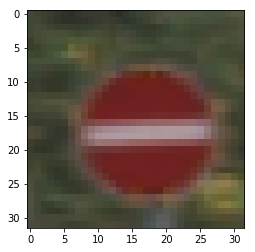

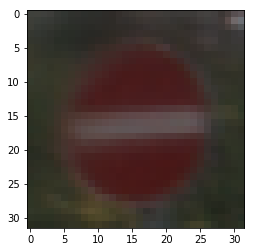

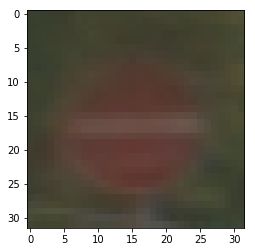

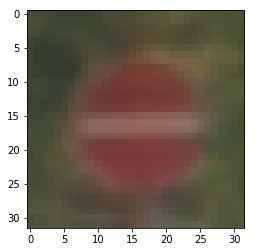

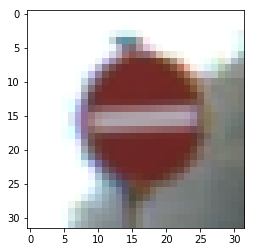

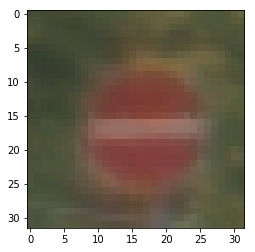

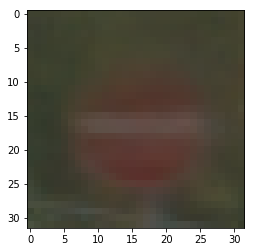

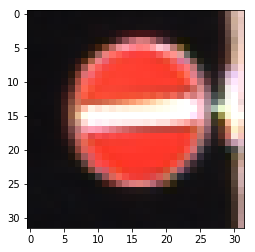

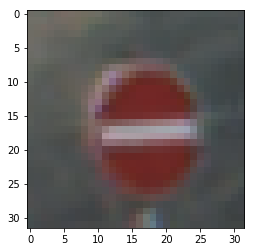

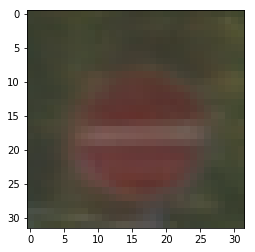

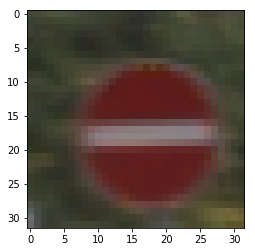

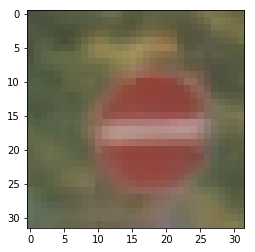

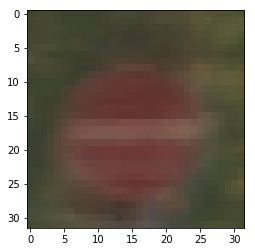

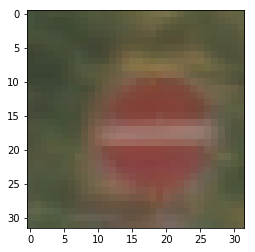

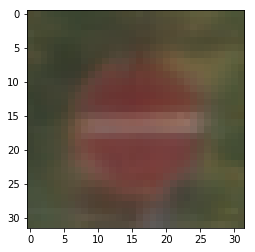

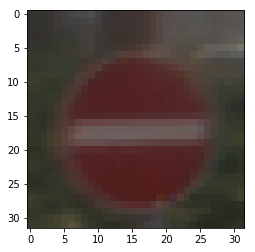

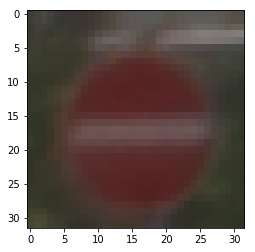

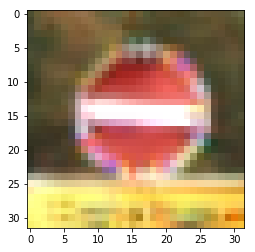

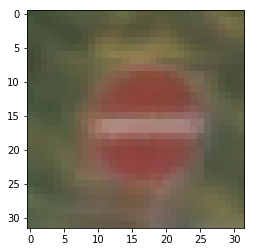

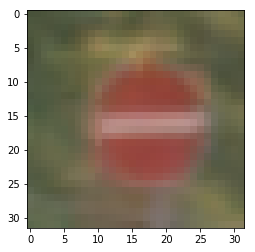

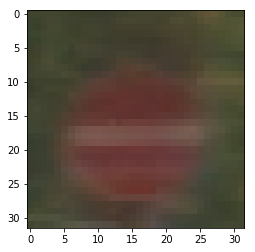

In [30]:
for i in X[:50]:
    plt.imshow(i)
    plt.show()

[array([[0.9994192]], dtype=float32), array([[0.9961467]], dtype=float32), array([[0.78848314]], dtype=float32), array([[0.9997768]], dtype=float32), array([[0.9999999]], dtype=float32), array([[0.9999795]], dtype=float32), array([[1.]], dtype=float32), array([[0.9999913]], dtype=float32)]
[array([[7.4505706]], dtype=float32), array([[5.5549455]], dtype=float32), array([[1.3158063]], dtype=float32), array([[8.407247]], dtype=float32), array([[16.258326]], dtype=float32), array([[10.792689]], dtype=float32), array([[19.82194]], dtype=float32), array([[11.657983]], dtype=float32)]


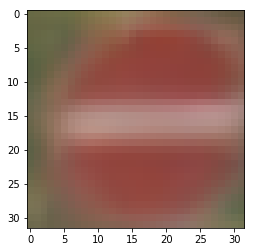

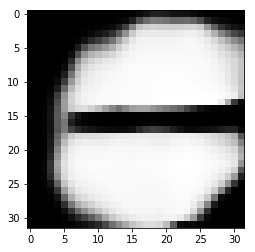

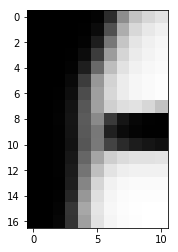

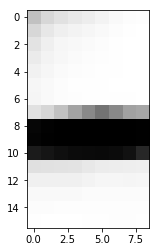

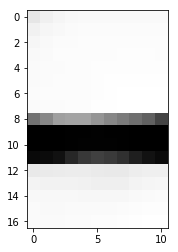

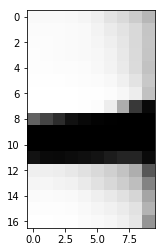

In [31]:
i = np.random.choice(len(X))

x = X[i][np.newaxis]

y = get_output([x])[0]

feed_dict = {featnet.model.get_input_at(0): x}
scores = sess.run([featnet.feat_scores, featnet.before_sigmoid], feed_dict=feed_dict)
print(scores[0])
print(scores[1])

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()

In [72]:
# Attack on featnet + orig model

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.1,
              'eps_iter': 0.01,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 50,
              'rand_init': False,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 3, sess=sess)
adv = pgd.generate_np(X_atk, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:721: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-11-09 21:06:32,373 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [73]:
y_pred = model.predict(adv)
m_suc = np.argmax(y_pred, axis=1) == 14
f_suc = featnet.predict_model(sess, adv)[:, 0] >= 3
both = np.logical_and(m_suc, f_suc)
print("Attack success on orig clf: ", np.mean(m_suc))
print("Attack success on featnet: ", np.mean(f_suc))
print("Attack success on both: ", np.mean(both))

ind = np.where(both)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.0
Attack success on featnet:  0.0
Attack success on both:  0.0
Mean successful l-2 dist:  nan
Mean successful l-inf dist:  nan


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


[array([[0.9995895]], dtype=float32), array([[0.99470925]], dtype=float32), array([[0.99925417]], dtype=float32), array([[0.99022526]], dtype=float32), array([[0.98725533]], dtype=float32), array([[0.9803741]], dtype=float32), array([[0.9996823]], dtype=float32), array([[0.996637]], dtype=float32)]
[array([[7.7977605]], dtype=float32), array([[5.236491]], dtype=float32), array([[7.200338]], dtype=float32), array([[4.61813]], dtype=float32), array([[4.349813]], dtype=float32), array([[3.9110804]], dtype=float32), array([[8.054214]], dtype=float32), array([[5.6915507]], dtype=float32)]


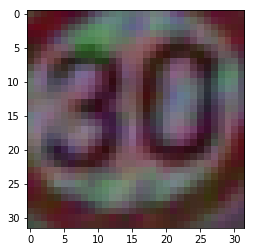

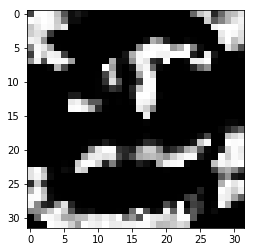

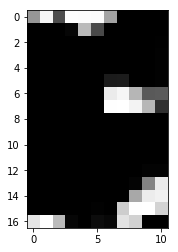

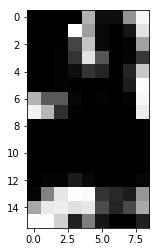

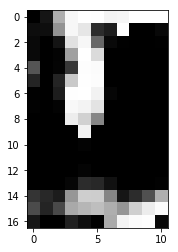

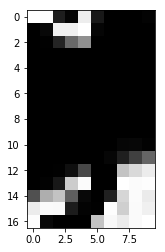

In [50]:
i = np.random.choice(ind)

x = adv[i][np.newaxis]

y = get_output([x])[0]

feed_dict = {featnet.model.get_input_at(0): x}
scores = sess.run([featnet.feat_scores, featnet.before_sigmoid], feed_dict=feed_dict)
print(scores[0])
print(scores[1])

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()